In [2]:
import gymnasium as gym
from mountaincar_wrapper import MountainCarWrapper
from bettermdptools.utils.test_env import TestEnv
from bettermdptools.algorithms.planner import Planner
from bettermdptools.utils.plots import Plots
from rl import RL
from myutils import test_env
#from expected_reward_history import expected_reward_history
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time

from planner import PlannerR

In [3]:
from multiprocessing import Pool
import workers_a4
import os

def expected_reward_history(space_dims, pi_track, output_step=1, n_episodes=1000, nproc=4):
    e_track = list(range(0, len(pi_track), output_step))
    if e_track[-1] < len(pi_track)-1: e_track += [len(pi_track)-1]
    parameters = []
    output_file = 'temp'
    for e in e_track:
        parameters.append((space_dims, e, pi_track[e], n_episodes, output_file))
        
    if __name__ ==  '__main__':
        p=Pool(processes = nproc)
        p.map(workers_a4.mc_expected_reward, parameters)

    R_track = np.loadtxt(output_file, delimiter=' ')
    R_track = R_track[R_track[:, 0].argsort()]
    os.remove(output_file)

    return R_track

In [4]:
def test_env_mc(env, n_iters, pi, convert_state_obs=lambda state: state):
    test_scores = np.full([n_iters], np.nan)
    test_state_history = []
    for i in range(0, n_iters):
        state_iter = []
        state, info = env.reset(seed=i)
        done = False
        state = convert_state_obs(state)
        total_reward = 0
        while not done:
            state_iter.append(state)
            action = pi[state]
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            next_state = convert_state_obs(next_state)
            state = next_state
            total_reward += reward
        test_scores[i] = total_reward
        test_state_history.append(state_iter)
        env.close()
    return test_scores, test_state_history

def index_to_position_list(state_index_history, position_range, position_bins, velocity_bins):
    position_idx = np.unravel_index(state_index_history, (position_bins, velocity_bins), order='C')[0]
    return np.linspace(*position_range, position_bins)[position_idx]
    

In [4]:
base_env = gym.make('MountainCar-v0', render_mode=None)
mountaincar = MountainCarWrapper(base_env, position_bins=100, velocity_bins=100, model=False)

n_episodes = 200000
Q_track_episodes = [100, 1000, 10000, 100000, n_episodes]
pi_track_episodes = list(range(0, n_episodes, 5000)) + [n_episodes-1]

In [5]:
base_env = gym.make('MountainCar-v0', render_mode=None)
mountaincar = MountainCarWrapper(base_env, position_bins=100, velocity_bins=100, model=False)

n_episodes = 200000
Q_track_episodes = [100, 1000, 10000, 100000, n_episodes]
pi_track_episodes = list(range(0, n_episodes, 5000)) + [n_episodes-1]

tic = time.perf_counter()
Q, V, pi, Q_track, pi_track = RL(mountaincar).q_learning(nS=mountaincar.observation_space, nA=mountaincar.action_space.n, 
                                                         n_episodes=n_episodes, 
                                                         Q_track_episodes=Q_track_episodes, 
                                                         pi_track_episodes=pi_track_episodes, seed=100)
toc = time.perf_counter()
print("Q-Learning training time:", toc-tic)

pi_track_arr = np.array(pi_track)
pi_arr = np.array(list(pi.values()))

outfile = 'v2_rl_100bins_dflt_'
np.savez(outfile+'Q_track', Q_track=Q_track)
np.savez(outfile+'pi_track', pi_track_arr=pi_track_arr)
np.savez(outfile+'final', Q=Q, V=V, pi_arr=pi_arr)
del Q, V, pi, Q_track, pi_track, pi_track_arr, pi_arr

  0%|          | 0/200000 [00:00<?, ?it/s]C:\Users\akoutras\Documents\ml\a4\v2_rl_mountaincar\rl.py:194: UserWarning: Episode was truncated.  TD target value may be incorrect.
  warnings.warn("Episode was truncated.  TD target value may be incorrect.")
                                                         

Q-Learning training time: 6150.011264599976


Total reward Mean:  -126.6664 , std:  21.035510714979086 , max:  -86.0 , min:  -162.0


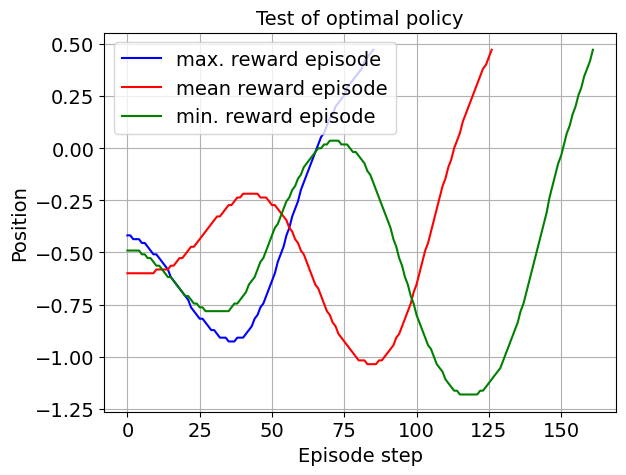

In [6]:
outfile = 'v2_rl_100bins_dflt_'
npzfile = np.load(outfile +'final'+'.npz', allow_pickle=True)
pi_arr = npzfile['pi_arr']
pi = {s: a for s, a in enumerate(pi_arr)}
del npzfile, pi_arr

#test policy
test_scores, test_state_history = test_env_mc(env=mountaincar, n_iters=10000, pi=pi)
#del pi
print('Total reward Mean: ', np.mean(test_scores), ', std: ', np.std(test_scores), ', max: ', np.max(test_scores), ', min: ', np.min(test_scores))

max_rwrd_idx = np.argmax(test_scores)
min_rwrd_idx = np.argmin(test_scores)
avg_rwrd_idx = np.abs(test_scores - np.mean(test_scores)).argmin()

position_range = (-1.2, 0.6)
position_bins = 100
velocity_bins = 100
max_position_history = index_to_position_list( test_state_history[max_rwrd_idx], position_range, position_bins, velocity_bins)
min_position_history = index_to_position_list( test_state_history[min_rwrd_idx], position_range, position_bins, velocity_bins)
avg_position_history = index_to_position_list( test_state_history[avg_rwrd_idx], position_range, position_bins, velocity_bins)

fontsize = 14
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(range(len(max_position_history)), max_position_history, label=f'max. reward episode', color='blue')
ax.plot(range(len(avg_position_history)), avg_position_history, label=f'mean reward episode', color='red')
ax.plot(range(len(min_position_history)), min_position_history, label=f'min. reward episode', color='green')
ax.tick_params(labelsize=fontsize)
ax.set_title('Test of optimal policy', fontsize=fontsize)
ax.set_xlabel('Episode step', fontsize=fontsize) 
ax.set_ylabel('Position', fontsize=fontsize)
#ax.set_xlim(0, 15000)
plt.grid(True)
#ax.set_ylim(0.2, 1)
ax.legend(fontsize=fontsize)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

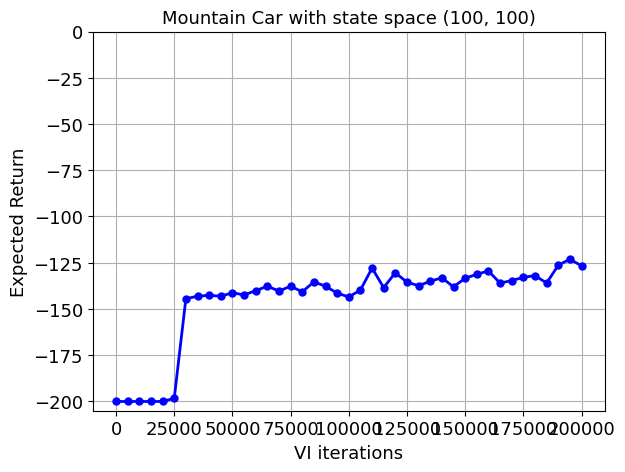

In [6]:
n_episodes = 200000
Q_track_episodes = [100, 1000, 10000, 100000, n_episodes]
pi_track_episodes = list(range(0, n_episodes, 5000)) + [n_episodes-1]

outfile = 'v2_rl_100bins_dflt_'
npzfile = np.load(outfile +'pi_track'+'.npz', allow_pickle=True)
pi_track = npzfile['pi_track_arr']

space_dims = (100, 100)
pi_track_episodes = list(range(0, n_episodes, 5000)) + [n_episodes-1]
R_track = expected_reward_history(space_dims=space_dims, pi_track=pi_track, output_step=1, n_episodes=10000, nproc=8)

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(pi_track_episodes, list(R_track[:,1]), '-o', color='blue', markersize=5, linewidth=2)

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car with state space (100, 100)', fontsize=fontsize)
ax.set_xlabel('VI iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
#ax.legend(fontsize=fontsize)
ax.set_ylim(-205, 0)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

R_track_e100 = R_track

del npzfile, pi_track, R_track

In [8]:
base_env = gym.make('MountainCar-v0', render_mode=None)
mountaincar = MountainCarWrapper(base_env, position_bins=50, velocity_bins=50, model=False)
n_episodes = 200000
Q_track_episodes = [100, 1000, 10000, 100000, n_episodes]
pi_track_episodes = list(range(0, n_episodes, 5000)) + [n_episodes-1]

In [9]:

tic = time.perf_counter()
Q, V, pi, Q_track, pi_track = RL(mountaincar).q_learning(nS=mountaincar.observation_space, nA=mountaincar.action_space.n, 
                                                         n_episodes=n_episodes, 
                                                         Q_track_episodes=Q_track_episodes, 
                                                         pi_track_episodes=pi_track_episodes, seed=50)
toc = time.perf_counter()
print("Q-Learning training time:", toc-tic)

pi_track_arr = np.array(pi_track)
pi_arr = np.array(list(pi.values()))

outfile = 'v2_rl_50bins_dflt_'
np.savez(outfile+'Q_track', Q_track=Q_track)
np.savez(outfile+'pi_track', pi_track_arr=pi_track_arr)
np.savez(outfile+'final', Q=Q, V=V, pi_arr=pi_arr)
del Q, V, pi, Q_track, pi_track, pi_track_arr, pi_arr

Q-Learning training time: 5691.70157159993


Total reward Mean:  -109.093 , std:  22.180724762730364 , max:  -85.0 , min:  -176.0


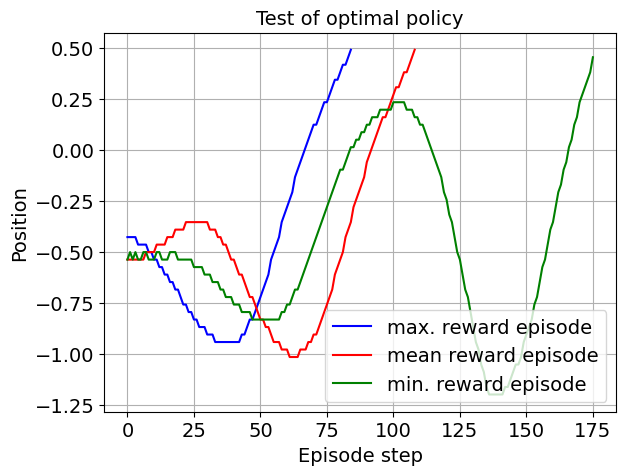

In [10]:
outfile = 'v2_rl_50bins_dflt_'
npzfile = np.load(outfile +'final'+'.npz', allow_pickle=True)
pi_arr = npzfile['pi_arr']
pi = {s: a for s, a in enumerate(pi_arr)}
del npzfile, pi_arr

#test policy
test_scores, test_state_history = test_env_mc(env=mountaincar, n_iters=10000, pi=pi)
#del pi
print('Total reward Mean: ', np.mean(test_scores), ', std: ', np.std(test_scores), ', max: ', np.max(test_scores), ', min: ', np.min(test_scores))

max_rwrd_idx = np.argmax(test_scores)
min_rwrd_idx = np.argmin(test_scores)
avg_rwrd_idx = np.abs(test_scores - np.mean(test_scores)).argmin()

position_range = (-1.2, 0.6)
position_bins = 50
velocity_bins = 50
max_position_history = index_to_position_list( test_state_history[max_rwrd_idx], position_range, position_bins, velocity_bins)
min_position_history = index_to_position_list( test_state_history[min_rwrd_idx], position_range, position_bins, velocity_bins)
avg_position_history = index_to_position_list( test_state_history[avg_rwrd_idx], position_range, position_bins, velocity_bins)

fontsize = 14
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(range(len(max_position_history)), max_position_history, label=f'max. reward episode', color='blue')
ax.plot(range(len(avg_position_history)), avg_position_history, label=f'mean reward episode', color='red')
ax.plot(range(len(min_position_history)), min_position_history, label=f'min. reward episode', color='green')
ax.tick_params(labelsize=fontsize)
ax.set_title('Test of optimal policy', fontsize=fontsize)
ax.set_xlabel('Episode step', fontsize=fontsize) 
ax.set_ylabel('Position', fontsize=fontsize)
#ax.set_xlim(0, 15000)
plt.grid(True)
#ax.set_ylim(0.2, 1)
ax.legend(fontsize=fontsize)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

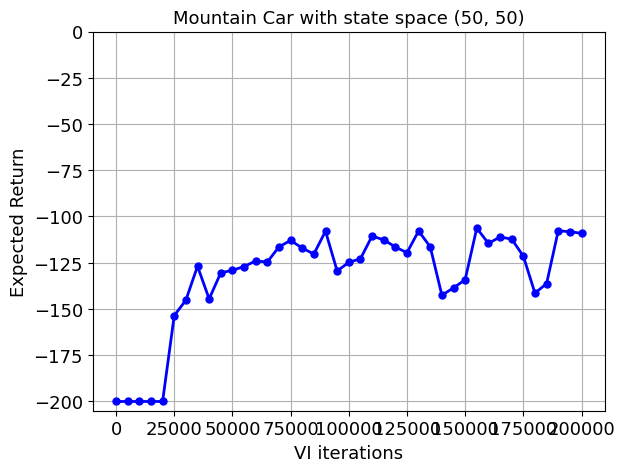

In [7]:
n_episodes = 200000
Q_track_episodes = [100, 1000, 10000, 100000, n_episodes]
pi_track_episodes = list(range(0, n_episodes, 5000)) + [n_episodes-1]

outfile = 'v2_rl_50bins_dflt_'
npzfile = np.load(outfile +'pi_track'+'.npz', allow_pickle=True)
pi_track = npzfile['pi_track_arr']

space_dims = (50, 50)
pi_track_episodes = list(range(0, n_episodes, 5000)) + [n_episodes-1]
R_track = expected_reward_history(space_dims=space_dims, pi_track=pi_track, output_step=1, n_episodes=10000, nproc=8)

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(pi_track_episodes, list(R_track[:,1]), '-o', color='blue', markersize=5, linewidth=2)

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car with state space (50, 50)', fontsize=fontsize)
ax.set_xlabel('VI iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
#ax.legend(fontsize=fontsize)
ax.set_ylim(-205, 0)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

R_track_e50 = R_track

del npzfile, pi_track, R_track

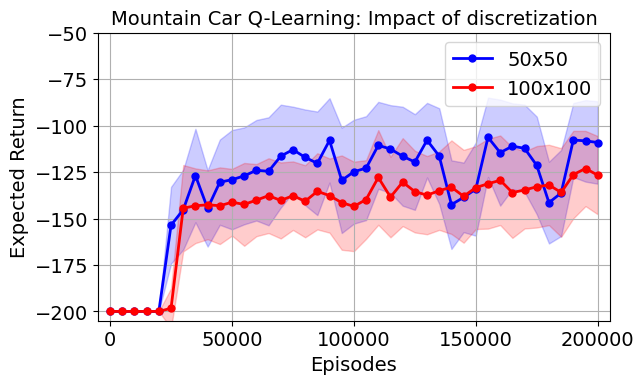

In [26]:
fontsize = 14
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.60])
ax.plot(pi_track_episodes, list(R_track_e50[:,1]), '-o', color='blue', label='50x50', markersize=5, linewidth=2)
ax.fill_between(pi_track_episodes, R_track_e50[:,1]-R_track_e50[:,2], R_track_e50[:,1]+R_track_e50[:,2], alpha=0.2, color="b")

ax.plot(pi_track_episodes, list(R_track_e100[:,1]), '-o', color='red', label='100x100', markersize=5, linewidth=2)
ax.fill_between(pi_track_episodes, R_track_e100[:,1]-R_track_e100[:,2], R_track_e100[:,1]+R_track_e100[:,2], alpha=0.2, color="r")

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car Q-Learning: Impact of discretization', fontsize=fontsize)
ax.set_xlabel('Episodes', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
ax.set_xlim(-5000, 205000)
ax.set_xticks([0, 50000, 100000, 150000, 200000])
plt.grid(True)
ax.legend(fontsize=fontsize)
ax.set_ylim(-205, -50)
plt.show()
fig.savefig('mc_rl_discr.png')
plt.close(fig)

In [15]:
base_env = gym.make('MountainCar-v0', render_mode=None)
mountaincar = MountainCarWrapper(base_env, position_bins=50, velocity_bins=50, model=False)

n_episodes = 200000
Q_track_episodes = [100, 1000, 10000, 100000, n_episodes]
pi_track_episodes = list(range(0, n_episodes, 5000)) + [n_episodes-1]

tic = time.perf_counter()
Q, V, pi, Q_track, pi_track = RL(mountaincar).q_learning(nS=mountaincar.observation_space, nA=mountaincar.action_space.n, 
                                                         n_episodes=n_episodes, 
                                                         Q_track_episodes=Q_track_episodes, epsilon_decay_ratio=0.1, min_epsilon=0.01,
                                                         pi_track_episodes=pi_track_episodes, seed=52)
toc = time.perf_counter()
print("Q-Learning training time:", toc-tic)

pi_track_arr = np.array(pi_track)
pi_arr = np.array(list(pi.values()))

outfile = 'v2_rl_50bins_d01_m001'
np.savez(outfile+'Q_track', Q_track=Q_track)
np.savez(outfile+'pi_track', pi_track_arr=pi_track_arr)
np.savez(outfile+'final', Q=Q, V=V, pi_arr=pi_arr)
del Q, V, pi, Q_track, pi_track, pi_track_arr, pi_arr


Q-Learning training time: 5090.285693700076


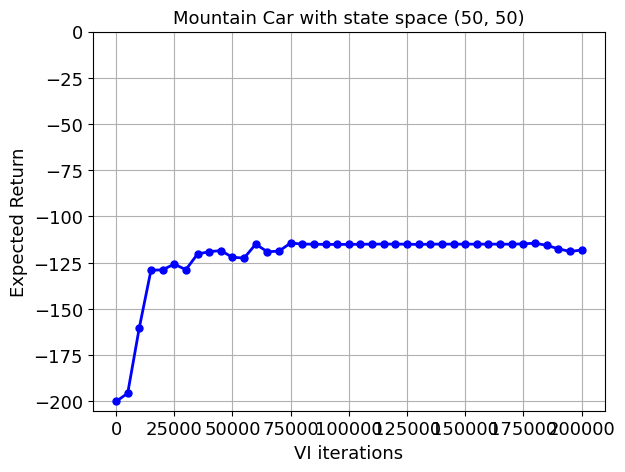

In [8]:
n_episodes = 200000
Q_track_episodes = [100, 1000, 10000, 100000, n_episodes]
pi_track_episodes = list(range(0, n_episodes, 5000)) + [n_episodes-1]

outfile = 'v2_rl_50bins_d01_m001'
npzfile = np.load(outfile +'pi_track'+'.npz', allow_pickle=True)
pi_track = npzfile['pi_track_arr']

space_dims = (50, 50)
pi_track_episodes = list(range(0, n_episodes, 5000)) + [n_episodes-1]
R_track = expected_reward_history(space_dims=space_dims, pi_track=pi_track, output_step=1, n_episodes=10000, nproc=8)

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(pi_track_episodes, list(R_track[:,1]), '-o', color='blue', markersize=5, linewidth=2)

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car with state space (50, 50)', fontsize=fontsize)
ax.set_xlabel('VI iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
#ax.legend(fontsize=fontsize)
ax.set_ylim(-205, 0)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

R_track_e52 = R_track

del npzfile, pi_track, R_track

In [12]:
base_env = gym.make('MountainCar-v0', render_mode=None)
mountaincar = MountainCarWrapper(base_env, position_bins=50, velocity_bins=50, model=False)

n_episodes = 200000
Q_track_episodes = [100, 1000, 10000, 100000, n_episodes]
pi_track_episodes = list(range(0, n_episodes, 5000)) + [n_episodes-1]

tic = time.perf_counter()
Q, V, pi, Q_track, pi_track = RL(mountaincar).q_learning(init_alpha=0.1, nS=mountaincar.observation_space, nA=mountaincar.action_space.n, 
                                                         n_episodes=n_episodes, 
                                                         Q_track_episodes=Q_track_episodes, 
                                                         pi_track_episodes=pi_track_episodes, seed=51)
toc = time.perf_counter()
print("Q-Learning training time:", toc-tic)

pi_track_arr = np.array(pi_track)
pi_arr = np.array(list(pi.values()))

outfile = 'v2_rl_50bins_a01'
np.savez(outfile+'Q_track', Q_track=Q_track)
np.savez(outfile+'pi_track', pi_track_arr=pi_track_arr)
np.savez(outfile+'final', Q=Q, V=V, pi_arr=pi_arr)
del Q, V, pi, Q_track, pi_track, pi_track_arr, pi_arr


Q-Learning training time: 6016.303431899985


Total reward Mean:  -139.3543 , std:  24.24479679250787 , max:  -89.0 , min:  -200.0


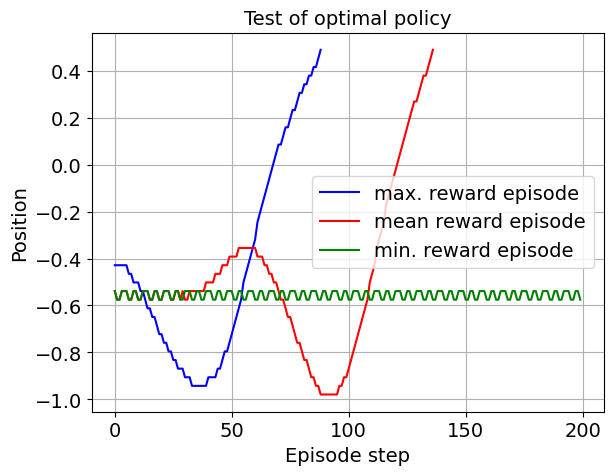

In [13]:
outfile = 'v2_rl_50bins_a01'
npzfile = np.load(outfile +'final'+'.npz', allow_pickle=True)
pi_arr = npzfile['pi_arr']
pi = {s: a for s, a in enumerate(pi_arr)}
del npzfile, pi_arr

#test policy
test_scores, test_state_history = test_env_mc(env=mountaincar, n_iters=10000, pi=pi)
#del pi
print('Total reward Mean: ', np.mean(test_scores), ', std: ', np.std(test_scores), ', max: ', np.max(test_scores), ', min: ', np.min(test_scores))

max_rwrd_idx = np.argmax(test_scores)
min_rwrd_idx = np.argmin(test_scores)
avg_rwrd_idx = np.abs(test_scores - np.mean(test_scores)).argmin()

position_range = (-1.2, 0.6)
position_bins = 50
velocity_bins = 50
max_position_history = index_to_position_list( test_state_history[max_rwrd_idx], position_range, position_bins, velocity_bins)
min_position_history = index_to_position_list( test_state_history[min_rwrd_idx], position_range, position_bins, velocity_bins)
avg_position_history = index_to_position_list( test_state_history[avg_rwrd_idx], position_range, position_bins, velocity_bins)

fontsize = 14
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(range(len(max_position_history)), max_position_history, label=f'max. reward episode', color='blue')
ax.plot(range(len(avg_position_history)), avg_position_history, label=f'mean reward episode', color='red')
ax.plot(range(len(min_position_history)), min_position_history, label=f'min. reward episode', color='green')
ax.tick_params(labelsize=fontsize)
ax.set_title('Test of optimal policy', fontsize=fontsize)
ax.set_xlabel('Episode step', fontsize=fontsize) 
ax.set_ylabel('Position', fontsize=fontsize)
#ax.set_xlim(0, 15000)
plt.grid(True)
#ax.set_ylim(0.2, 1)
ax.legend(fontsize=fontsize)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

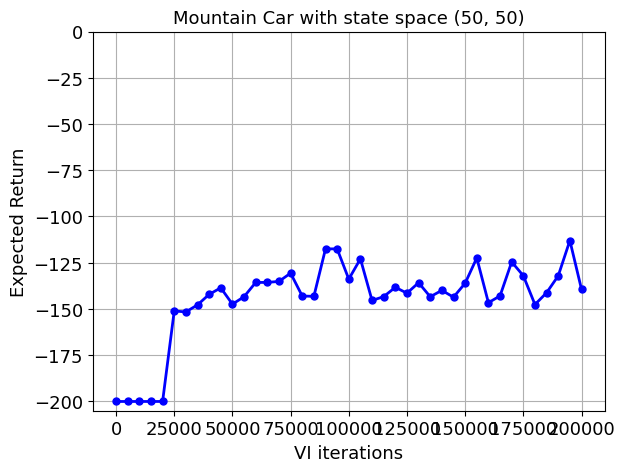

In [9]:
n_episodes = 200000
Q_track_episodes = [100, 1000, 10000, 100000, n_episodes]
pi_track_episodes = list(range(0, n_episodes, 5000)) + [n_episodes-1]

outfile = 'v2_rl_50bins_a01'
npzfile = np.load(outfile +'pi_track'+'.npz', allow_pickle=True)
pi_track = npzfile['pi_track_arr']

space_dims = (50, 50)
pi_track_episodes = list(range(0, n_episodes, 5000)) + [n_episodes-1]
R_track = expected_reward_history(space_dims=space_dims, pi_track=pi_track, output_step=1, n_episodes=10000, nproc=8)

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(pi_track_episodes, list(R_track[:,1]), '-o', color='blue', markersize=5, linewidth=2)

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car with state space (50, 50)', fontsize=fontsize)
ax.set_xlabel('VI iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
#ax.legend(fontsize=fontsize)
ax.set_ylim(-205, 0)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

R_track_e51 = R_track

del npzfile, pi_track, R_track

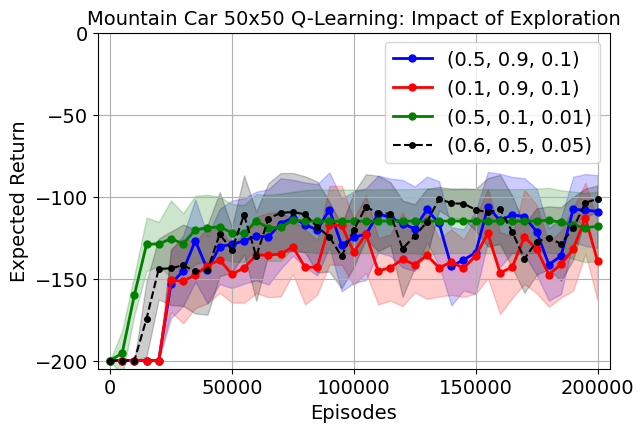

In [31]:
fontsize = 14
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.70])
ax.plot(pi_track_episodes, list(R_track_e50[:,1]), '-o', color='blue', label='(0.5, 0.9, 0.1)', markersize=5, linewidth=2)
ax.fill_between(pi_track_episodes, R_track_e50[:,1]-R_track_e50[:,2], R_track_e50[:,1]+R_track_e50[:,2], alpha=0.2, color="b")

ax.plot(pi_track_episodes, list(R_track_e51[:,1]), '-o', color='red', label='(0.1, 0.9, 0.1)', markersize=5, linewidth=2)
ax.fill_between(pi_track_episodes, R_track_e51[:,1]-R_track_e51[:,2], R_track_e51[:,1]+R_track_e51[:,2], alpha=0.2, color="r")

ax.plot(pi_track_episodes, list(R_track_e52[:,1]), '-o', color='green', label='(0.5, 0.1, 0.01)', markersize=5, linewidth=2)
ax.fill_between(pi_track_episodes, R_track_e52[:,1]-R_track_e52[:,2], R_track_e52[:,1]+R_track_e52[:,2], alpha=0.2, color="g")

ax.plot(pi_track_episodes, list(R_track_e50_a06[:,1]), '--o', color='black', label='(0.6, 0.5, 0.05)', markersize=4, linewidth=1.5)
ax.fill_between(pi_track_episodes, R_track_e50_a06[:,1]-R_track_e50_a06[:,2], R_track_e50_a06[:,1]+R_track_e50_a06[:,2], alpha=0.2, color="k")

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car 50x50 Q-Learning: Impact of Exploration', fontsize=fontsize)
ax.set_xlabel('Episodes', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
ax.set_xlim(-5000, 205000)
ax.set_xticks([0, 50000, 100000, 150000, 200000])
plt.grid(True)
ax.legend(fontsize=fontsize)
ax.set_ylim(-205, 0)
plt.show()
fig.savefig('mc_rl_parametric.png')
plt.close(fig)

In [28]:
# Grid search best parameters

base_env = gym.make('MountainCar-v0', render_mode=None)
mountaincar = MountainCarWrapper(base_env, position_bins=50, velocity_bins=50, model=False)

n_episodes = 200000
Q_track_episodes = [100, 1000, 10000, 100000, n_episodes]
pi_track_episodes = list(range(0, n_episodes, 5000)) + [n_episodes-1]

tic = time.perf_counter()
Q, V, pi, Q_track, pi_track = RL(mountaincar).q_learning(init_alpha=0.6, nS=mountaincar.observation_space, nA=mountaincar.action_space.n, 
                                                         n_episodes=n_episodes, 
                                                         Q_track_episodes=Q_track_episodes, epsilon_decay_ratio=0.5, min_epsilon=0.05, 
                                                         pi_track_episodes=pi_track_episodes, seed=112)
toc = time.perf_counter()
print("Q-Learning training time:", toc-tic)

pi_track_arr = np.array(pi_track)
pi_arr = np.array(list(pi.values()))

outfile = 'v2_rl_50bins_a06'
np.savez(outfile+'Q_track', Q_track=Q_track)
np.savez(outfile+'pi_track', pi_track_arr=pi_track_arr)
np.savez(outfile+'final', Q=Q, V=V, pi_arr=pi_arr)
del Q, V, pi, Q_track, pi_track, pi_track_arr, pi_arr


  0%|          | 0/200000 [00:00<?, ?it/s]C:\Users\akoutras\Documents\ml\a4\v2_rl_mountaincar\rl.py:194: UserWarning: Episode was truncated.  TD target value may be incorrect.
  warnings.warn("Episode was truncated.  TD target value may be incorrect.")


Q-Learning training time: 5435.259225700051


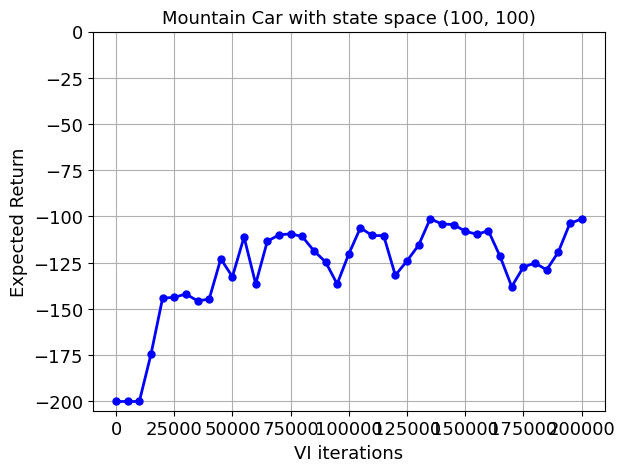

In [29]:
outfile = 'v2_rl_50bins_a06'
npzfile = np.load(outfile +'pi_track'+'.npz', allow_pickle=True)
pi_track = npzfile['pi_track_arr']

space_dims = (50, 50)
pi_track_episodes = list(range(0, n_episodes, 5000)) + [n_episodes-1]
R_track = expected_reward_history(space_dims=space_dims, pi_track=pi_track, output_step=1, n_episodes=10000, nproc=18)

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(pi_track_episodes, list(R_track[:,1]), '-o', color='blue', markersize=5, linewidth=2)

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car with state space (100, 100)', fontsize=fontsize)
ax.set_xlabel('VI iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
#ax.legend(fontsize=fontsize)
ax.set_ylim(-205, 0)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

R_track_e50_a06 = R_track

del npzfile, pi_track, R_track

Text(0.5, 1.0, 'Value function for the state space 50x50')

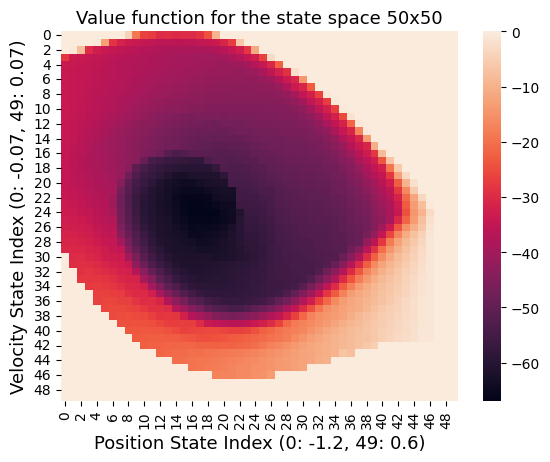

In [35]:
outfile = 'v2_rl_50bins_a06'
npzfile = np.load(outfile +'final'+'.npz', allow_pickle=True)
pi_arr = npzfile['pi_arr']
V = npzfile['V']
del npzfile

pi = {s:a for s, a in enumerate(pi_arr)}

data = V
size = (50,50)
data = np.array(data).reshape(size).T
df = pd.DataFrame(data=data)

ax=sns.heatmap(df, annot=False) #cmap=sns.color_palette("Blues", as_cmap=True), vmin=-40, vmax=0
ax.set_xlabel('Position State Index (0: -1.2, 49: 0.6)', fontsize=13) 
ax.set_ylabel('Velocity State Index (0: -0.07, 49: 0.07)', fontsize=13)
ax.set_title('Value function for the state space 50x50', fontsize=13)

Text(0.5, 1.0, 'Optimal policy for the state space 50x50')

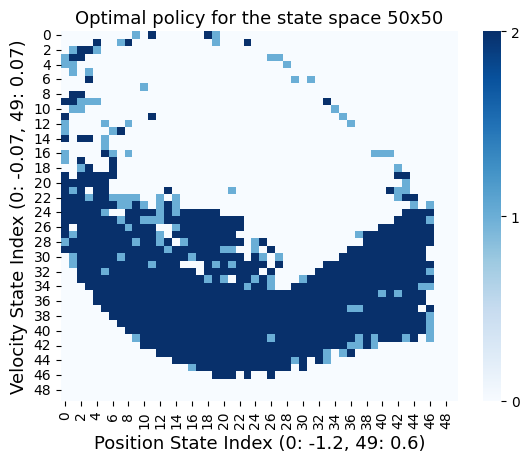

In [36]:
best_action = np.zeros(V.shape[0], dtype=np.int32)
for idx, val in enumerate(V):
    best_action[idx] = pi[idx]

data = best_action
size = (50,50)
data = np.array(data).reshape(size).T
df = pd.DataFrame(data=data)
ax=sns.heatmap(df, annot=False, cmap=sns.color_palette("Blues", as_cmap=True),
           cbar_kws={"ticks": [0, 1, 2]})
ax.set_xlabel('Position State Index (0: -1.2, 49: 0.6)', fontsize=13) 
ax.set_ylabel('Velocity State Index (0: -0.07, 49: 0.07)', fontsize=13)
ax.set_title('Optimal policy for the state space 50x50', fontsize=13)

In [38]:
#test policy
base_env = gym.make('MountainCar-v0', render_mode=None)
mountaincar = MountainCarWrapper(base_env, position_bins=50, velocity_bins=50, model=False)

outfile = 'v2_rl_50bins_a06'
npzfile = np.load(outfile +'final'+'.npz', allow_pickle=True)
pi_arr = npzfile['pi_arr']
del npzfile

pi = {s:a for s, a in enumerate(pi_arr)}

test_scores, test_state_history = test_env_mc(env=mountaincar, n_iters=10000, pi=pi)
print('Total reward Mean: ', np.mean(test_scores), ', std: ', np.std(test_scores), ', max: ', np.max(test_scores), ', min: ', np.min(test_scores))

max_rwrd_idx = np.argmax(test_scores)
min_rwrd_idx = np.argmin(test_scores)
avg_rwrd_idx = np.abs(test_scores - np.mean(test_scores)).argmin()

position_range = (-1.2, 0.6)
position_bins = 50
velocity_bins = 50 
max_position_history = index_to_position_list( test_state_history[max_rwrd_idx], position_range, position_bins, velocity_bins)
min_position_history = index_to_position_list( test_state_history[min_rwrd_idx], position_range, position_bins, velocity_bins)
avg_position_history = index_to_position_list( test_state_history[avg_rwrd_idx], position_range, position_bins, velocity_bins)

Total reward Mean:  -101.3776 , std:  8.0646523942449 , max:  -85.0 , min:  -132.0


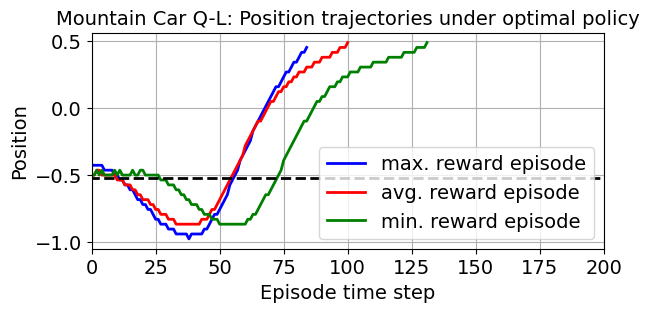

In [43]:
fontsize = 14
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.45])
ax.plot(range(len(max_position_history)), max_position_history, label=f'max. reward episode', color='blue', linewidth=2)
ax.plot(range(len(avg_position_history)), avg_position_history, label=f'avg. reward episode', color='red', linewidth=2)
ax.plot(range(len(min_position_history)), min_position_history, label=f'min. reward episode', color='green', linewidth=2)
ax.plot([-1, 200], [-0.5236, -0.5236], '--', color='k', linewidth=2)
ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car Q-L: Position trajectories under optimal policy', fontsize=fontsize)
ax.set_xlabel('Episode time step', fontsize=fontsize) 
ax.set_ylabel('Position', fontsize=fontsize)
ax.set_xlim(-0, 200)
plt.grid(True)
#ax.set_ylim(0.2, 1)
ax.legend(fontsize=14, loc='lower right')
plt.show()
fig.savefig('mc_ql_optimal_position_hist.png')
plt.close(fig)

In [ ]:
from multiprocessing import Pool
import importlib
importlib.reload(workers_a4)
#importlib.reload(rl)
import workers_a4
#from rl import RL

init_alpha_list = [0.5, 0.6]
n_episodes_list = [200000]
min_eps_list = [0.01, 0.05, 0.1, 0.2]
decay_eps_list = [0.3, 0.5, 0.7, 0.9]

output_file = 'v2_rl_QL_grid_search'

parameters = []
seed=100
for i, n_episodes in enumerate(n_episodes_list):
    for j, min_eps in enumerate(min_eps_list):
        for k, decay_eps in enumerate(decay_eps_list):
            for kk, init_alpha in enumerate(init_alpha_list):

                seed += 1
                
                parameters.append((seed, init_alpha, decay_eps, min_eps, n_episodes, output_file))

print('seed','init_alpha','decay_eps', 'min_eps', 'n_episodes', file=open(output_file+'_progress.txt', 'a'))
print('seed','init_alpha','decay_eps', 'min_eps', 'n_episodes', 'exp_R', 'time', file=open(output_file+'_results.txt', 'a'))

if __name__ ==  '__main__':
    p=Pool(processes = 22)
    p.map(workers_a4.mc_QL_grid_seach, parameters)
    print('Done!')